# Test1: classify galaxies with SimCLR trained with CIPAR10

In [1]:
import torch
import numpy as np

import atm
import atm.simclr as simclr

In [2]:
import argparse 

args = argparse.Namespace()

args.data='./datasets' 
args.dataset_name='cifar10'
args.arch='resnet50'
args.workers=1
args.epochs=300 
args.batch_size=256 
args.lr=0.02
args.wd=0.0005
args.disable_cuda=False
args.fp16_precision=True
args.out_dim=128
args.log_every_n_steps=100
args.temperature=0.07
args.n_views = 2
args.gpu_index=0
args.device='cuda' if torch.cuda.is_available() else 'cpu'

print("Using device:", args.device)

Using device: cpu


/home/hoseung/anaconda3/envs/tm39/lib/python3.8/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448278899/work/c10/cuda/CUDAFunctions.cpp:115.)
  return torch._C._cuda_getDeviceCount() > 0


## Load trained ResNet (1-channel)

In [3]:
checkpoint = torch.load('./runs/Sep02_18-05-11_hoseung-kasi/checkpoint_0100.pth.tar', map_location=args.device)
state_dict = checkpoint['state_dict']

resnet = simclr.models.ResNetSimCLR(base_model=args.arch, out_dim=args.out_dim)
resnet.to(args.device)
log = resnet.load_state_dict(state_dict, strict=False)

print(log)

<All keys matched successfully>


### Visualize trained feature vectors

In [4]:
import matplotlib.pyplot as plt 

### Test with CIFAR10 first

In [5]:
from tqdm import tqdm
from torch.cuda.amp import autocast
import torchvision
from torchvision import transforms

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    transforms.Lambda(lambda x: x.mean(dim=0, keepdim=True))
])

testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=100, shuffle=False, num_workers=2)

Files already downloaded and verified


## First, verify the training result. 

tensorboard shows reasonable curves for both accuracy and loss. top5 accuracy of 93.39% after 38.9k steps. 

그렇다면, 내가 엉뚱한 feature를 뽑아내는 것인가? 

In [6]:
feature_arr = []
label_arr = []
for images, l in tqdm(testloader):
    images = images.to(args.device)

    # autocast <- AMP
    with autocast(enabled=args.fp16_precision):
        features = resnet.backbone(images)
        
    feature_arr.append(features.cpu().detach().numpy())
    label_arr.append(l)

feature_arr = np.concatenate(feature_arr)
label_arr = np.concatenate(label_arr)

  0%|          | 0/100 [00:00<?, ?it/s]/home/hoseung/anaconda3/envs/tm39/lib/python3.8/site-packages/torch/cuda/amp/autocast_mode.py:120: UserWarning: torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.")
/home/hoseung/anaconda3/envs/tm39/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448278899/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
100%|██████████| 100/100 [00:07<00:00, 13.76it/s]


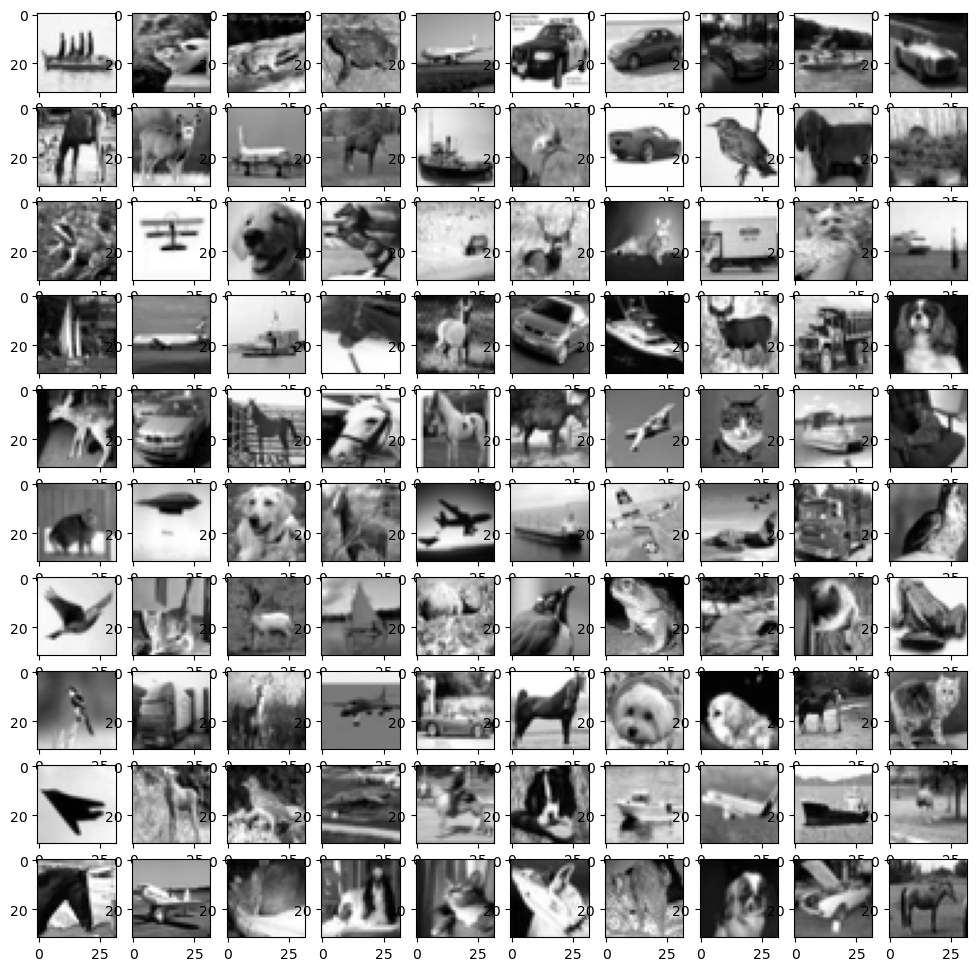

In [21]:
fig, axs = plt.subplots(10,10, figsize=(12,12))

axs = axs.ravel()

for ax, img in zip(axs, images):
    img = img.squeeze(0).to('cpu')
    ax.imshow(img, cmap='gray')
    
plt.show()

OK, channel-averaged images all look reasonable!

What about feature vectors? 
1. Do feature vectors of the same/different classes look similar/different?
2. What's the expected range of feature vector values? 
3. How does averagaed feature vector of each class compare? -- draw ridge plots

In [41]:
from astrobf.utils import plots

In [68]:
#def ridge_plot(data, categories, var_name, cat_name,
import matplotlib
from sklearn.neighbors import KernelDensity
import matplotlib.gridspec as grid_spec

cmap = 'Spectral'
figsize=(9,18)
ymax=None
bandwidth=None
nband=200
hspace=-0.8
fn_fig='feature_vector_plots_'

cmap = matplotlib.cm.get_cmap(cmap)


categories = np.arange(n_feat)
n_catagories = len(categories)
colors = cmap(np.linspace(0,1,n_catagories))

gs = grid_spec.GridSpec(n_catagories,1)


#xmin = data[var_name].min()
#xmax = data[var_name].max()


n_feat = 64 # first 50 features 
for this_label in np.arange(10):
#this_label=3
    fig = plt.figure(figsize=figsize)
    var_name = cat_name = f'cat{this_label}'
    ind = np.where(label_arr == this_label)[0]
    data = feature_arr[ind,:n_feat]
    print("selecting {} sample of label == {}".format(len(data), this_label))

    xmin = -3
    xamx = 3
    #xmin = data.min()
    #xmax = data.max()

    ax_objs = []
    heighs=[]
    if bandwidth is None:
        bandwidth = (xmax - xmin) / nband

    for i, species in enumerate(categories):
        x = data[:,i]
        #x = np.array(data[var_name][data[cat_name] == species])
        x_d = np.linspace(xmin,xmax, 1000)

        kde = KernelDensity(bandwidth=bandwidth, kernel='gaussian')
        kde.fit(x[:, None])

        logprob = kde.score_samples(x_d[:, None])

        # creating new axes object
        ax_objs.append(fig.add_subplot(gs[i:i+1, 0:]))

        # plotting the distribution
        ax_objs[-1].plot(x_d, np.exp(logprob),color="#f0f0f0",lw=1)
        ax_objs[-1].fill_between(x_d, np.exp(logprob), alpha=1,color=colors[i])

        # setting uniform x axis
        ax_objs[-1].set_xlim(xmin, xmax)

        # store heights
        heighs.append(max(np.exp(logprob)))
        #ax_objs[-1].set_ylim(0,ymax)

        # make background transparent
        rect = ax_objs[-1].patch
        rect.set_alpha(0)

        # remove borders, axis ticks, and labels
        ax_objs[-1].set_yticklabels([])

        if i == len(categories)-1:
            ax_objs[-1].set_xlabel(var_name, fontsize=16,fontweight="bold")
        else:
            ax_objs[-1].set_xticklabels([])

        spines = ["top","right","left","bottom"]
        for s in spines:
            ax_objs[-1].spines[s].set_visible(False)

        label = f'{species}'
        ax_objs[-1].text(xmax + 0.05*(xmax-xmin),0,label,fontweight="bold",fontsize=14,ha="right")

    if ymax is None:
        ymax = 0.7*(np.mean(heighs)+max(heighs))
    for ax in ax_objs:
        ax.set_ylim(0,ymax)
    gs.update(hspace=hspace)
    ax_objs[0].text(0.5*(xmax+xmin), ymax, var_name+' vs '+cat_name, fontweight="bold",fontsize=14)
    plt.tight_layout()
    if fn_fig is not None:
        plt.savefig(fn_fig+cat_name+'.png', facecolor='white')
        plt.close()
    else:
        plt.show()
        

selecting 1000 sample of label == 0


<ipython-input-68-e0761054ebe9>:96: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


selecting 1000 sample of label == 1


<ipython-input-68-e0761054ebe9>:96: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


selecting 1000 sample of label == 2


<ipython-input-68-e0761054ebe9>:96: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


selecting 1000 sample of label == 3


<ipython-input-68-e0761054ebe9>:96: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


selecting 1000 sample of label == 4


<ipython-input-68-e0761054ebe9>:96: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


selecting 1000 sample of label == 5


<ipython-input-68-e0761054ebe9>:96: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


selecting 1000 sample of label == 6


<ipython-input-68-e0761054ebe9>:96: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


selecting 1000 sample of label == 7


<ipython-input-68-e0761054ebe9>:96: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


selecting 1000 sample of label == 8


<ipython-input-68-e0761054ebe9>:96: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


selecting 1000 sample of label == 9


<ipython-input-68-e0761054ebe9>:96: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


눈으로 봐선 잘 모르겠음. 특별히 skew된 feature가 잘 안 보이기도 하고, 다 너무 비슷하고 무작위함. 
범위는 대충 -3 ~ +3정도인 듯. 이정도면 OK인가? 

In [31]:
colors = {0:'tab:blue',
          1:'tab:orange',
          2:'tab:green',
          3:'tab:red',
          4:'tab:purple',
          5:'tab:brown',
          6:'tab:pink',
          7:'tab:gray',
          8:'tab:olive',
          9:'tab:cyan'}

In [34]:
plt.close('all')

In [38]:
label_arr[:20]

array([3, 8, 8, 0, 6, 6, 1, 6, 3, 1, 0, 9, 5, 7, 9, 8, 5, 7, 8, 6])

In [39]:
i0 = np.where(label_arr == 0)[0]

In [40]:
plt.plot(np.average(feature_arr[i0])`

1000

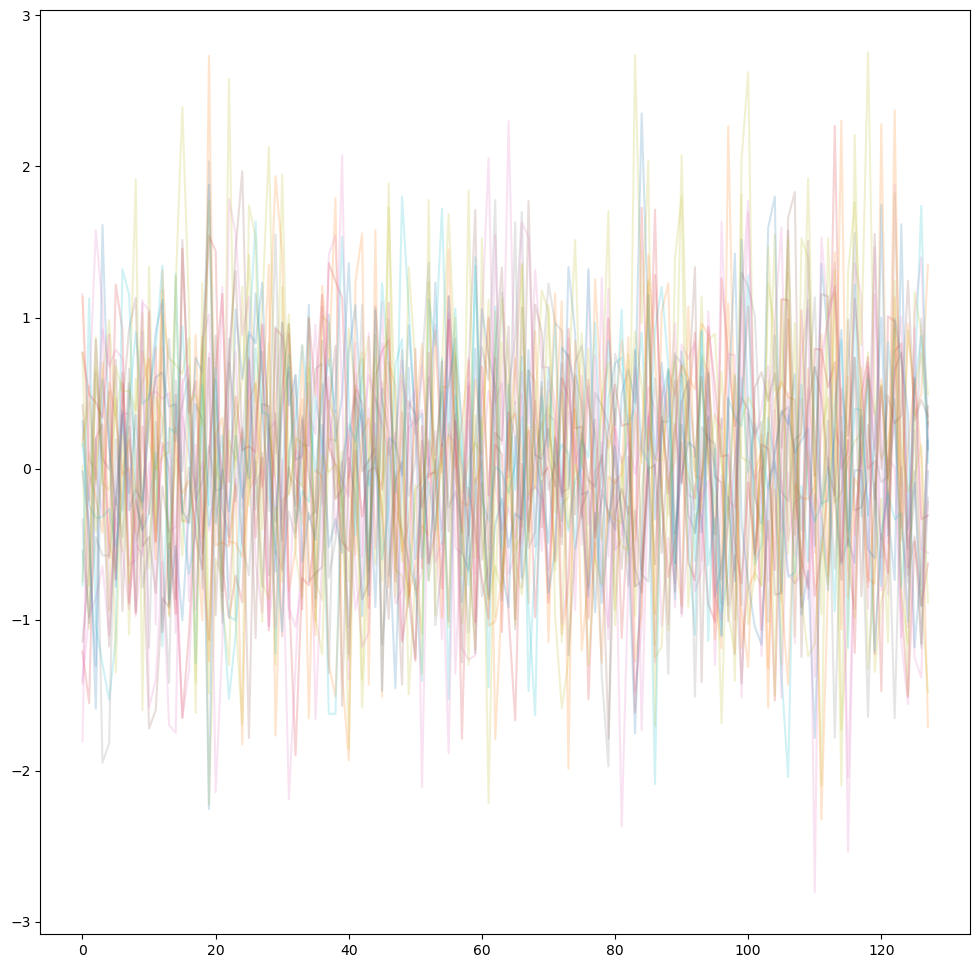

In [37]:
fig, ax = plt.subplots(figsize=(12,12))

for fta, lbl in zip(feature_arr[:20], label_arr[:20]):
    ax.plot(fta, alpha=0.2, c=colors[lbl])
    
plt.show()

In [7]:
print(feature_arr.shape)
print(feature_arr)


(10000, 128)
[[-1.209   -1.549    0.2003  ... -0.4824  -0.905   -0.6294 ]
 [-0.7485   0.1038  -0.1014  ...  0.4941   0.7617   0.3003 ]
 [ 0.01915 -1.06     0.8657  ...  1.168    0.8936   0.493  ]
 ...
 [-0.3198  -0.8047   0.1775  ...  0.291   -0.2017  -0.392  ]
 [ 0.3474   0.8613  -0.0581  ... -0.5957   0.4065  -0.2695 ]
 [-0.786    2.082    0.3184  ... -0.1355  -0.2112  -0.1403 ]]


Good, I got non-zero, diverse vectors

In [19]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, verbose=1, perplexity=200, n_iter=500)
# n_components : the number of reduced dimension.
# perplexity : (roughly) number of neighbors.
tsne_results = tsne.fit_transform(feature_arr)

[t-SNE] Computing 601 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.000s...
[t-SNE] Computed neighbors for 10000 samples in 1.953s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 2.930766
[t-SNE] KL divergence after 150 iterations with early exaggeration: 72.466637
[t-SNE] KL divergence after 500 iterations: 2.657676


In [20]:
plt.close('all')

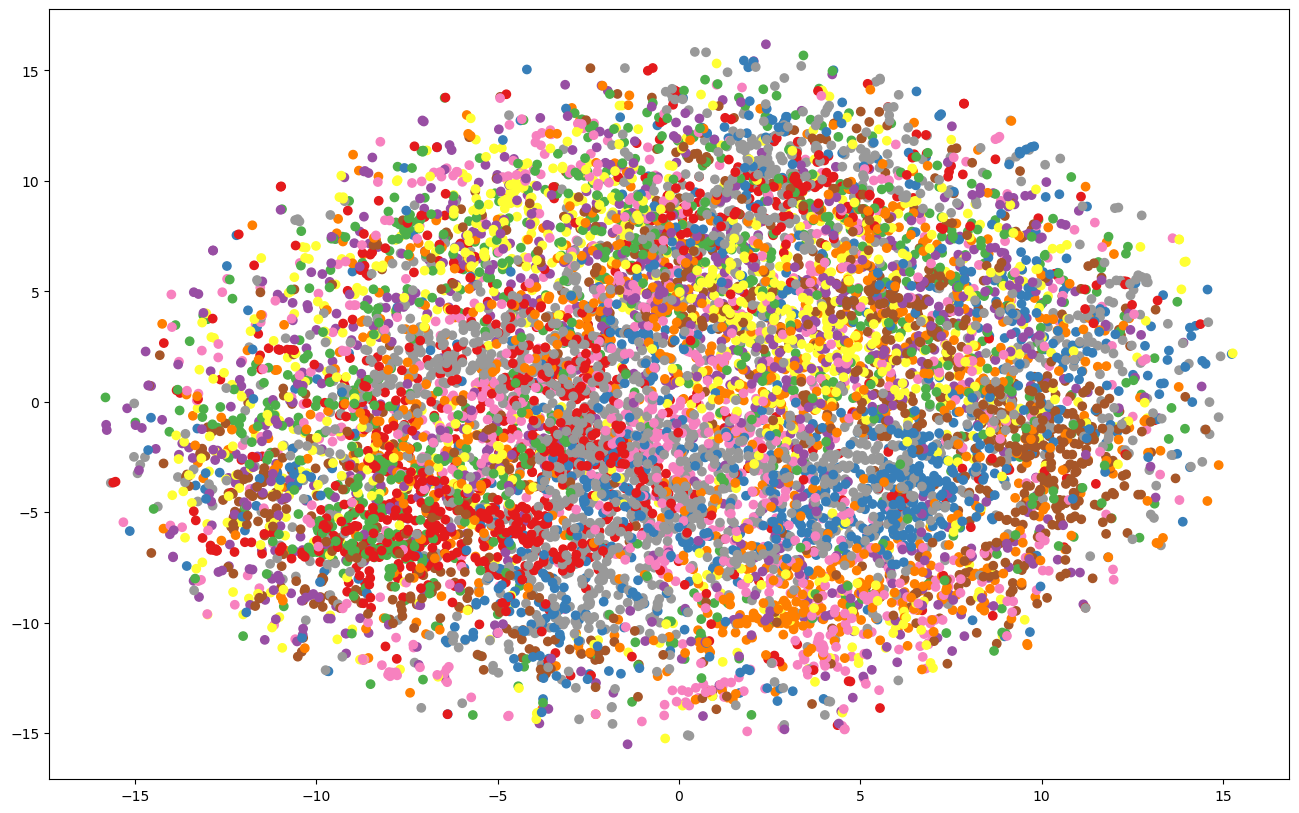

In [21]:
#df_subset['tsne-2d-one'] = tsne_results[:,0]
#df_subset['tsne-2d-two'] = tsne_results[:,1]
plt.figure(figsize=(16,10))
plt.scatter(tsne_results[:,0], tsne_results[:,1], c=label_arr, cmap='Set1')
plt.show()

이렇게 하는거 아닌가..? 왜 안 뭉치지... 

간단한 t-SNE 예제를 처음부터 해봐야겠다. 흠.

In [22]:
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="y",
    palette=sns.color_palette("hls", 10),
    data=df_subset,
    legend="full",
    alpha=0.3
)

NameError: name 'df_subset' is not defined

## Test with Galaxy Images next